# Imports

In [1]:
import numpy as np
import tensorflow as tf
from common.model import create_ssm, get_ssm_weights, set_ssm_weights
from common.data import generate_inputs, create_one_hot_array
from common.train import train

np.set_printoptions(linewidth=200)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[3:4], 'GPU')

2025-02-01 16:39:17.015787: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 16:39:20.196328: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 16:39:20.197527: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-02-01 16:39:20.250953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 16:39:20.251690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573

# Global variables

In [2]:
sd_baseline = 1
sd_special = 1
epochs = int(1e6)
log_period = 100
print_period = int(1e4)
n_evals = 7
epochs_after_opt = 1500

# Length = 6, teacher state dim = 3, student state dim = 10

## Shared setup

In [3]:
seed = 401
teacher_state_dim = 3
student_state_dim = 10
sd_A = 0.01
sd_B_C = 0.01
length = 6
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(2 * np.log10(1 / sd_A))

In [4]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
A[2, 2] = 0.5
B[0, 0] = 1
B[0, 1] = 1
B[0, 2] = 1
C[0, 0] = 1
C[1, 0] = 1
C[2, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

2025-02-01 16:39:20.323969: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 16:39:20.325918: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-01 16:39:20.326838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2025-02-01 16:39:20.326913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-02-01 16:39:20.326979: I tensorflow/stream_executor/

## 8 baseline inputs, 0 special inputs

In [5]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
title = 'SSM,\nwithout special sequences'

In [6]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

2025-02-01 16:39:21.441213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2025-02-01 16:39:21.902249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-02-01 16:39:21.919983: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 3.367889165878296
7 absolute largest EVs of A: [0.01485123 0.01393502 0.0139258  0.01007344 0.00805713 0.00764574 0.00626401]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10000
Train loss: 0.03059433028101921
7 absolute largest EVs of A: [1.0694919  0.0559346  0.05534585 0.01407933 0.00971038 0.00901594 0.00695281]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009908782318234444
7 absolute largest EVs of A: [1.0509344  0.59099823 0.38127187 0.01459167 0.00987539 0.00914442 0.00701238]
+-------------+
|Final results|
+-------------+
Train loss: 3.832239599432796e-05
7 absolute largest EVs of A: [9.8

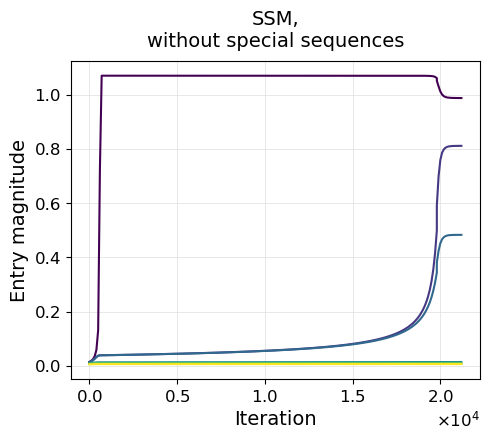

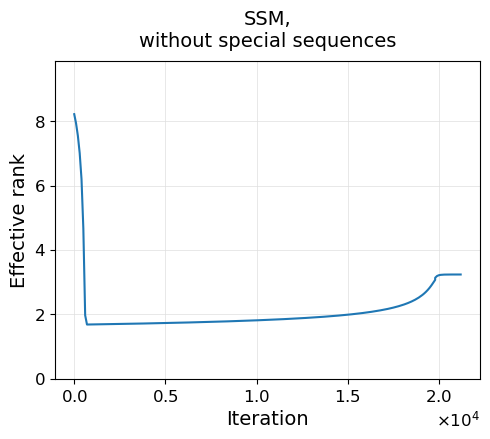

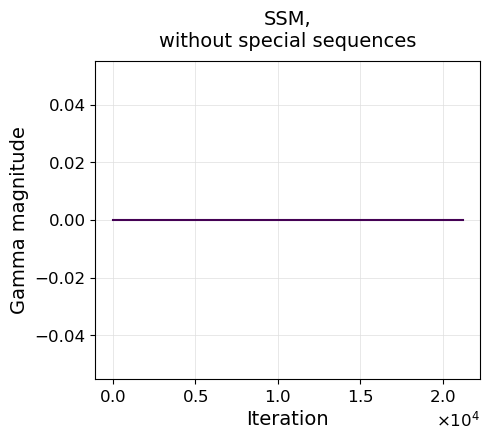

In [7]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim3=True, title=title)

## 8 baseline inputs, 10 special inputs

In [8]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [9]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 3.482110023498535
7 absolute largest EVs of A: [0.01485862 0.01393694 0.01392681 0.01007395 0.00806077 0.00764678 0.00626516]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009958242066204548
7 absolute largest EVs of A: [1.0617869  0.41328937 0.41115326 0.13934022 0.09343275 0.08605626 0.06473302]
+-------------+
|Final results|
+-------------+
Train loss: 0.006531315390020609
7 absolute largest EVs of A: [1.0587932  0.46181053 0.4587079  0.1203733  0.07252983 0.06498045 0.04331972 0.03482279 0.01518965 0.0043364 ]
------------------------------------------------------------------------------------------------------
-------------------------------------------------------

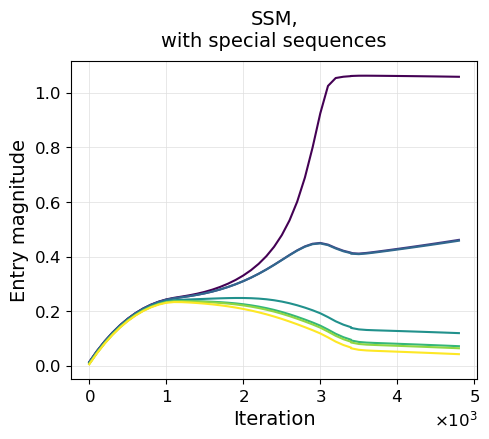

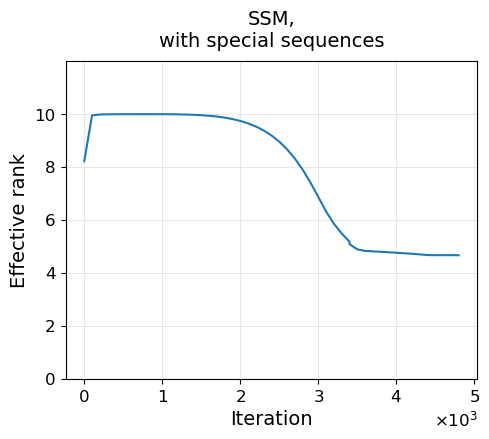

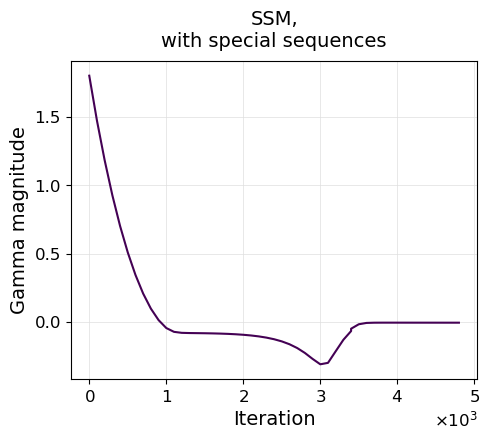

In [10]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim3=True, title=title)

# Length = 10, teacher state dim = 3, student state dim = 20

## Shared setup

In [11]:
seed = 1201
teacher_state_dim = 3
student_state_dim = 20
sd_A = 0.01
sd_B_C = 0.001
length = 10
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(3 * np.log10(1 / sd_A))

In [12]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
A[2, 2] = 0.5
B[0, 0] = 1
B[0, 1] = 1
B[0, 2] = 1
C[0, 0] = 1
C[1, 0] = 1
C[2, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 8 baseline inputs, 0 special inputs

In [13]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
title = 'SSM,\nwithout special sequences'

In [14]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 22.660648345947266
7 absolute largest EVs of A: [0.02018796 0.02006402 0.0200628  0.01688016 0.01506086 0.01354757 0.01140294]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009937047027051449
7 absolute largest EVs of A: [1.0074958  0.65759885 0.6517703  0.06927314 0.04513496 0.03342369 0.02263116]
+-------------+
|Final results|
+-------------+
Train loss: 0.0005667951190844178
7 absolute largest EVs of A: [0.99797887 0.6947961  0.6870423  0.06847489 0.04478014 0.0332241  0.02253797 0.01466404 0.01034735 0.01032568 0.00976329 0.00866299 0.00824286 0.00790559 0.00604662 0.00548087 0.00403712 0.00168036
 0.00145893 0.00108626]
---------------------------------------------

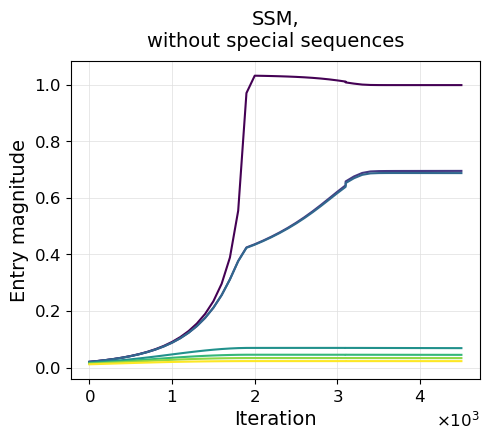

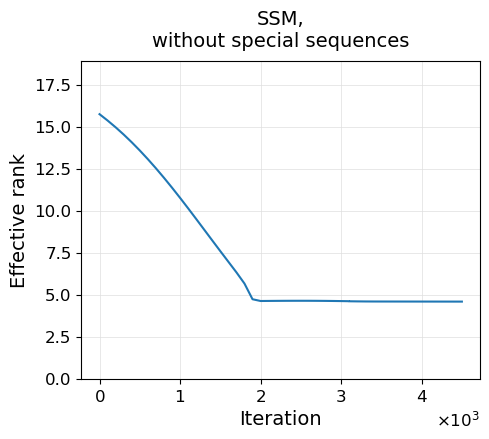

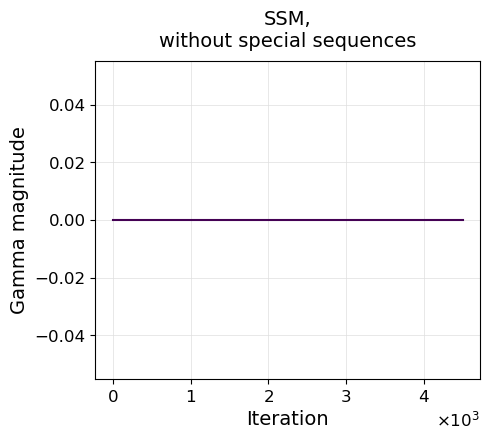

In [15]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim3=True, title=title)

## 8 baseline inputs, 10 special inputs

In [16]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [17]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 11.475680351257324
7 absolute largest EVs of A: [0.02018811 0.02006408 0.02006302 0.01688028 0.01506086 0.01354782 0.01140298]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009821870364248753
7 absolute largest EVs of A: [1.0066389  0.6577089  0.65643317 0.15770014 0.10138547 0.06986586 0.04474765]
+-------------+
|Final results|
+-------------+
Train loss: 0.0002738600014708936
7 absolute largest EVs of A: [9.9775720e-01 6.9174093e-01 6.8999934e-01 1.4390644e-01 8.9144386e-02 5.8279168e-02 5.6385569e-02 5.4632090e-02 5.3597614e-02 4.2917572e-02 3.6647264e-02 3.4243036e-02 2.6537511e-02 2.6102096e-02
 2.5168944e-02 2.3478279e-02 1.9114463e-02 1.6914587e-02 1.6831115e-02 

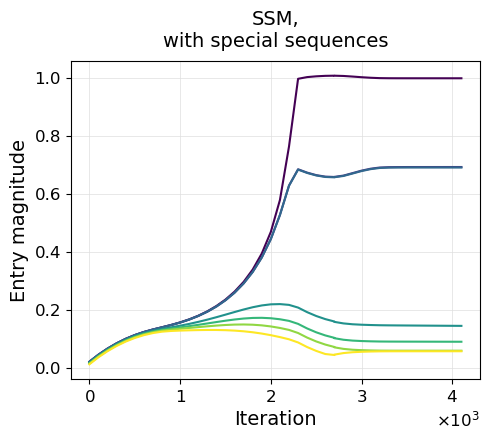

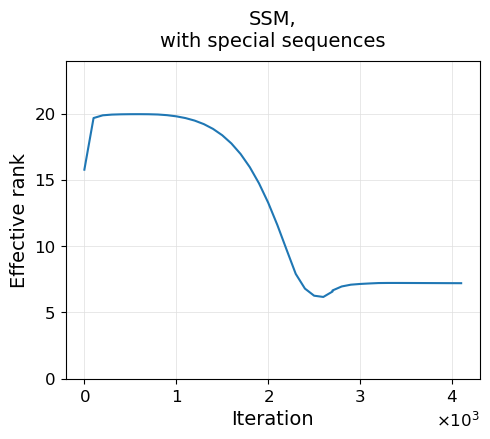

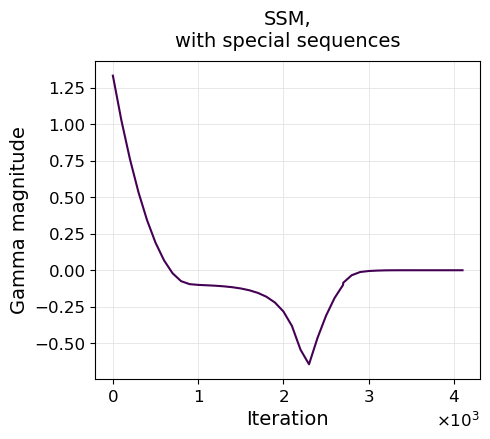

In [18]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, dim3=True, title=title)